#Import Statements



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

#Load Dataset

In [2]:
#from google.colab import files
#uploaded = files.upload()

df = pd.read_csv('Bank_Transaction_Fraud_Detection.csv')

# Data Cleaning

## Check for Missing Values

In [3]:
print(df.isna().sum())

Customer_ID                0
Customer_Name              0
Gender                     0
Age                        0
State                      0
City                       0
Bank_Branch                0
Account_Type               0
Transaction_ID             0
Transaction_Date           0
Transaction_Time           0
Transaction_Amount         0
Merchant_ID                0
Transaction_Type           0
Merchant_Category          0
Account_Balance            0
Transaction_Device         0
Transaction_Location       0
Device_Type                0
Is_Fraud                   0
Transaction_Currency       0
Customer_Contact           0
Transaction_Description    0
Customer_Email             0
dtype: int64


## Drop Irrelevant Columns

In [4]:
print(df.columns.tolist())

#drop columns
df = df.drop(columns=["Customer_ID", "Customer_Name", "Bank_Branch", "Transaction_ID", "Merchant_ID", "Transaction_Currency", "Customer_Contact", "Customer_Email"])
print(df.columns.tolist())

X = df.drop("Is_Fraud", axis=1)
y = df["Is_Fraud"]


['Customer_ID', 'Customer_Name', 'Gender', 'Age', 'State', 'City', 'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date', 'Transaction_Time', 'Transaction_Amount', 'Merchant_ID', 'Transaction_Type', 'Merchant_Category', 'Account_Balance', 'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Is_Fraud', 'Transaction_Currency', 'Customer_Contact', 'Transaction_Description', 'Customer_Email']
['Gender', 'Age', 'State', 'City', 'Account_Type', 'Transaction_Date', 'Transaction_Time', 'Transaction_Amount', 'Transaction_Type', 'Merchant_Category', 'Account_Balance', 'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Is_Fraud', 'Transaction_Description']


# Train-val-test split

In [5]:
# Train 70%, validation 10%, test 20%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp
)

#Feature Engineering

## One-Hot Encoding for Categorical Variables (Low Cardinality)

In [6]:
# Binary Encoding for Gender
for df in [X_train, X_val, X_test]:
    df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

In [7]:
cat_cols = ["Account_Type", "Merchant_Category", "Transaction_Type", "Device_Type"]

# One-hot encode train
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)

# One-hot encode val and test
X_val = pd.get_dummies(X_val, columns=cat_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)

# Align columns
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# pd.get_dummies automatically replaces the original columns with the new dummy columns so don't need to drop original columns already

In [8]:
print(X_train)

        Gender  Age              State                City Transaction_Date  \
68286        0   54            Manipur             Thoubal       16-01-2025   
194655       0   40         Puducherry            Karaikal       29-01-2025   
46200        0   20         Puducherry               Yanam       02-01-2025   
53297        0   64            Haryana              Ambala       18-01-2025   
54636        0   28        West Bengal             Asansol       01-01-2025   
...        ...  ...                ...                 ...              ...   
105337       0   28             Odisha             Cuttack       15-01-2025   
11544        1   19              Bihar              Munger       22-01-2025   
145077       0   41             Kerala  Thiruvananthapuram       12-01-2025   
108017       1   61             Kerala               Kochi       02-01-2025   
157724       0   61  Arunachal Pradesh            Itanagar       11-01-2025   

       Transaction_Time  Transaction_Amount  Accoun

In [9]:
# Convert bool to Binary
bool_cols_train = X_train.select_dtypes(include='bool').columns
X_train[bool_cols_train] = X_train[bool_cols_train].astype(int)

bool_cols_val = X_val.select_dtypes(include='bool').columns
X_val[bool_cols_val] = X_val[bool_cols_val].astype(int)

bool_cols_test = X_test.select_dtypes(include='bool').columns
X_test[bool_cols_test] = X_test[bool_cols_test].astype(int)

In [10]:
print(X_train.info())
print(X_val.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 140000 entries, 68286 to 157724
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Gender                           140000 non-null  int64  
 1   Age                              140000 non-null  int64  
 2   State                            140000 non-null  object 
 3   City                             140000 non-null  object 
 4   Transaction_Date                 140000 non-null  object 
 5   Transaction_Time                 140000 non-null  object 
 6   Transaction_Amount               140000 non-null  float64
 7   Account_Balance                  140000 non-null  float64
 8   Transaction_Device               140000 non-null  object 
 9   Transaction_Location             140000 non-null  object 
 10  Transaction_Description          140000 non-null  object 
 11  Account_Type_Business            140000 non-null  int64  
 12  Acc

## Top K Encoding for City (High Cardinality)

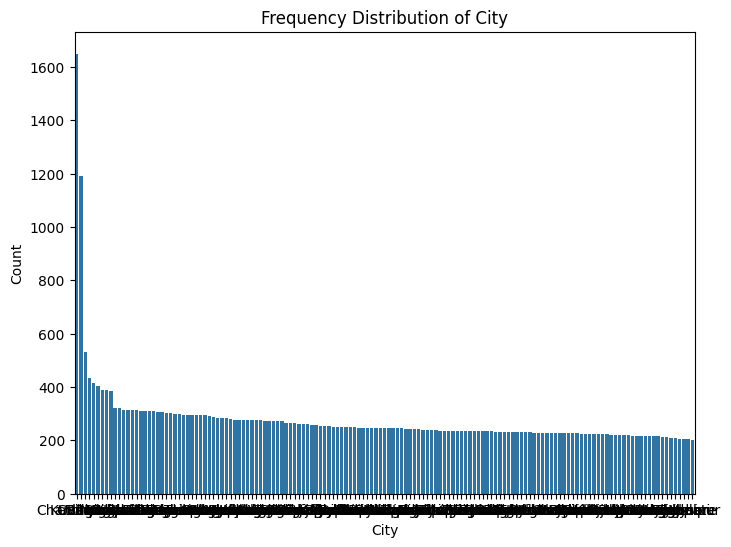

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='City', order=df['City'].value_counts().index)
plt.title("Frequency Distribution of City")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()

# Top 3 Encoding for City
top3_cities = X_train["City"].value_counts().nlargest(3).index
for df in [X_train, X_val, X_test]:
    for city in top3_cities:
        df[f"City_{city}"] = (df["City"] == city).astype(int)
    df["City_Other"] = (~df["City"].isin(top3_cities)).astype(int)

In [12]:
X_train.drop(columns=["City"], inplace=True)
X_val.drop(columns=["City"], inplace=True)
X_test.drop(columns=["City"], inplace=True)

In [13]:
print(X_train.head())

        Gender  Age        State Transaction_Date Transaction_Time  \
68286        0   54      Manipur       16-01-2025         06:25:10   
194655       0   40   Puducherry       29-01-2025         09:53:47   
46200        0   20   Puducherry       02-01-2025         11:01:43   
53297        0   64      Haryana       18-01-2025         01:59:13   
54636        0   28  West Bengal       01-01-2025         00:20:11   

        Transaction_Amount  Account_Balance Transaction_Device  \
68286               534.59         13373.15  Biometric Scanner   
194655            92813.86         91579.34                ATM   
46200             78998.52          5053.04    ATM Booth Kiosk   
53297              7724.99         17567.65  POS Mobile Device   
54636             49989.89         70304.65     POS Mobile App   

        Transaction_Location Transaction_Description  ...  \
68286       Thoubal, Manipur         Insurance claim  ...   
194655  Karaikal, Puducherry            Taxi booking  ...   

## Handling Temporal Features

In [14]:
# Cyclic Encoding for Transaction_Date
for df in [X_train, X_val, X_test]:
    df["Transaction_Date"] = pd.to_datetime(df["Transaction_Date"], errors="coerce", dayfirst=True)
    df["DayOfWeek"] = df["Transaction_Date"].dt.dayofweek  # Monday=0, Sunday=6
    df["DayOfWeek_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 7)
    df["DayOfWeek_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 7)

# Minutes after Midnight for Transaction_Time (works better for Tree-based such as RF, XGBoost, LightGBM, CatBoost)
for df in [X_train, X_val, X_test]:
    df["Transaction_Time"] = pd.to_datetime(df["Transaction_Time"], format='%H:%M:%S', errors='coerce').dt.time
    df["Minutes_After_Midnight"] = df["Transaction_Time"].apply(
        lambda x: x.hour * 60 + x.minute if pd.notnull(x) else np.nan
    )

    # Cyclic encoding (works better for logistic regression and neural networks)
    df["Time_sin"] = np.sin(2 * np.pi * df["Minutes_After_Midnight"] / 1440)
    df["Time_cos"] = np.cos(2 * np.pi * df["Minutes_After_Midnight"] / 1440)

In [15]:
X_train.drop(columns=["Transaction_Date", "Transaction_Time"], inplace=True)
X_val.drop(columns=["Transaction_Date", "Transaction_Time"], inplace=True)
X_test.drop(columns=["Transaction_Date", "Transaction_Time"], inplace=True)

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(140000, 36)
(20000, 36)
(40000, 36)


In [17]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 140000 entries, 68286 to 157724
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Gender                           140000 non-null  int64  
 1   Age                              140000 non-null  int64  
 2   State                            140000 non-null  object 
 3   Transaction_Amount               140000 non-null  float64
 4   Account_Balance                  140000 non-null  float64
 5   Transaction_Device               140000 non-null  object 
 6   Transaction_Location             140000 non-null  object 
 7   Transaction_Description          140000 non-null  object 
 8   Account_Type_Business            140000 non-null  int64  
 9   Account_Type_Checking            140000 non-null  int64  
 10  Account_Type_Savings             140000 non-null  int64  
 11  Merchant_Category_Clothing       140000 non-null  int64  
 12  Mer

## Create New Ratio Feature

In [18]:
# Ratio features with Transaction_Amount
X_train["Balance_to_Amount_Ratio"] = X_train["Account_Balance"] / X_train["Transaction_Amount"]
X_val["Balance_to_Amount_Ratio"] = X_val["Account_Balance"] / X_val["Transaction_Amount"]
X_test["Balance_to_Amount_Ratio"] = X_test["Account_Balance"] / X_test["Transaction_Amount"]

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(140000, 37)
(20000, 37)
(40000, 37)


## Target Encoding for High Cardinality Categorical Variables

In [20]:
# Target encoding
for col in ["State", "Transaction_Device", "Transaction_Location", "Transaction_Description"]:
    target_map = X_train.join(y_train).groupby(col)["Is_Fraud"].mean()
    X_train[col + "_TE"] = X_train[col].map(target_map)
    X_val[col + "_TE"] = X_val[col].map(target_map).fillna(0)  # unseen categories → 0
    X_test[col + "_TE"] = X_test[col].map(target_map).fillna(0)

In [21]:
X_train.drop(columns=["State", "Transaction_Device","Transaction_Location","Transaction_Description"], inplace=True)
X_val.drop(columns=["State", "Transaction_Device","Transaction_Location","Transaction_Description"], inplace=True)
X_test.drop(columns=["State", "Transaction_Device","Transaction_Location","Transaction_Description"], inplace=True)

In [22]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(140000, 37)
(20000, 37)
(40000, 37)


In [23]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 140000 entries, 68286 to 157724
Data columns (total 37 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Gender                           140000 non-null  int64  
 1   Age                              140000 non-null  int64  
 2   Transaction_Amount               140000 non-null  float64
 3   Account_Balance                  140000 non-null  float64
 4   Account_Type_Business            140000 non-null  int64  
 5   Account_Type_Checking            140000 non-null  int64  
 6   Account_Type_Savings             140000 non-null  int64  
 7   Merchant_Category_Clothing       140000 non-null  int64  
 8   Merchant_Category_Electronics    140000 non-null  int64  
 9   Merchant_Category_Entertainment  140000 non-null  int64  
 10  Merchant_Category_Groceries      140000 non-null  int64  
 11  Merchant_Category_Health         140000 non-null  int64  
 12  Mer

## Log-Transformation for Account_Balance

In [24]:
# Log-transformation for Account_Balance
X_train["Account_Balance_Log"] = np.log1p(X_train["Account_Balance"])
X_val["Account_Balance_Log"] = np.log1p(X_val["Account_Balance"])
X_test["Account_Balance_Log"] = np.log1p(X_test["Account_Balance"])

# SMOTE for Class Imbalance

In [25]:
# Initialise SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 132938, 1: 7062})
After SMOTE: Counter({0: 132938, 1: 132938})


# Save to csv


In [26]:
# Training set (resampled)
X_train_resampled.to_csv("X_train_resampled.csv", index=False)
y_train_resampled.to_csv("y_train_resampled.csv", index=False)

# Validation set
X_val.to_csv("X_val.csv", index=False)
y_val.to_csv("y_val.csv", index=False)

# Test set
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
